# Gold Layer - Optimizing for Specific Business Questions.

In [13]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, year, month, desc


from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))


# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For map making
import plotly.express as px

In [8]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("GoldBatchProcessor") \
    .master("local[*]") \
    .getOrCreate()

### Reading from our Silver Layer

In [9]:
# Path to the folder
silver_data_folder = '../data/silver_data'

# Find the actual CSV file in the folder
csv_file = [f for f in os.listdir(silver_data_folder) if f.endswith('.csv')][0]
silver_data_path = os.path.join(silver_data_folder, csv_file)

# Read the CSV file into a DataFrame
df_silver = spark.read.option("header", True).csv(silver_data_path)

# Show the reloaded DataFrame
df_silver.show(10)

+--------------------+------------+----------+-----------+------+---+-------------+--------------------+----------------+-----------------+-------------+--------------+---------------+-------------------+-------------+----------+-----------+----------------+
|Airport Country Code|Passenger ID|First Name|  Last Name|Gender|Age|  Nationality|        Airport Name|    Country Name|Airport Continent|   Continents|Departure Date|Arrival Airport|         Pilot Name|Flight Status|  latitude|  longitude|            name|
+--------------------+------------+----------+-----------+------+---+-------------+--------------------+----------------+-----------------+-------------+--------------+---------------+-------------------+-------------+----------+-----------+----------------+
|                  AU|      aogYWd|    Vernen|   Ivakhnov|  Male| 90|        China|     Mullewa Airport|       Australia|               OC|      Oceania|    2022-09-10|            MXU|     Lidia Kleinert|      Delayed|-25.2

## Age Distributions

/tmp/ipykernel_1763/3729341150.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


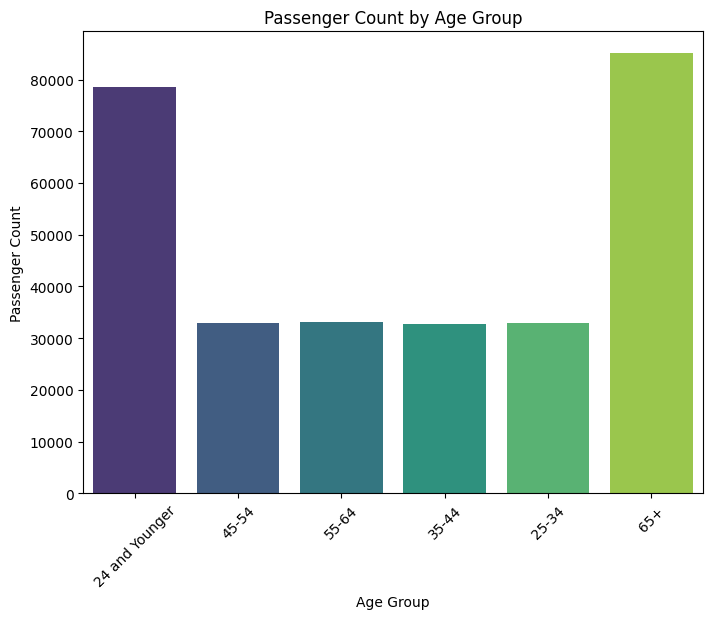

In [10]:
# Define age bins
df_binned = df_silver.withColumn(
    "Age Group",
    when((col("Age") < 25), "24 and Younger")
    .when((col("Age") >= 25) & (col("Age") < 35), "25-34")
    .when((col("Age") >= 35) & (col("Age") < 45), "35-44")
    .when((col("Age") >= 45) & (col("Age") < 55), "45-54")
    .when((col("Age") >= 55) & (col("Age") < 65), "55-64")
    .when((col("Age") >= 65), "65+")
    .otherwise("Unknown")  # Add an "Unknown" category for edge cases
)

# Group by "Age Group" and count passengers
age_group_counts = df_binned.groupBy("Age Group").count().withColumnRenamed("count", "Passenger Count")

# Convert to Pandas for visualization
age_group_pd = age_group_counts.toPandas()

# Normalize the "Passenger Count" column to scale the colors
norm = plt.Normalize(age_group_pd['Passenger Count'].min(), age_group_pd['Passenger Count'].max())
colors = sns.color_palette("viridis", as_cmap=True)(norm(age_group_pd['Passenger Count']))

# Create the bar plot with custom colors
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Age Group",
    y="Passenger Count",
    data=age_group_pd,
    palette=sns.color_palette("viridis", n_colors=len(age_group_pd))
)

# Add labels and formatting
plt.title("Passenger Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.show()


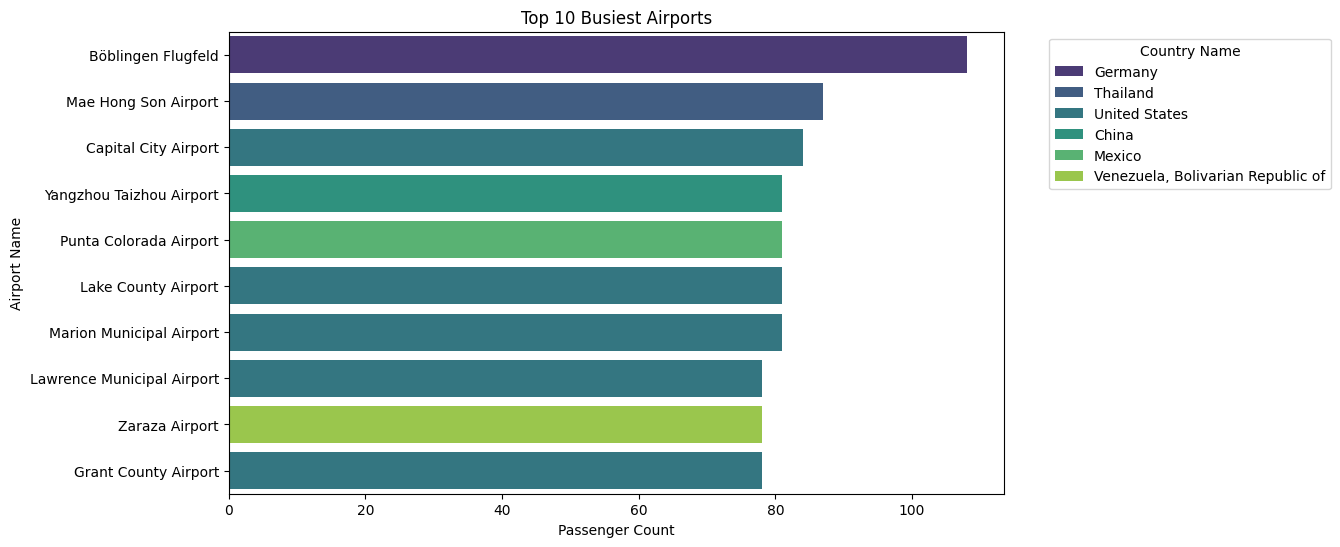

In [11]:
# Group by Airport Name and Country Name, and aggregate the passenger count
busiest_airports = df_silver.groupBy("Airport Name", "Country Name") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

# Convert to pandas for visualization
busiest_airports_pd = busiest_airports.toPandas()

# Plot the top 10 busiest airports
plt.figure(figsize=(10, 6))
sns.barplot(
    data=busiest_airports_pd,
    x="count",
    y="Airport Name",
    hue="Country Name",
    dodge=False,
    palette="viridis"
)
plt.title("Top 10 Busiest Airports")
plt.xlabel("Passenger Count")
plt.ylabel("Airport Name")
plt.legend(title="Country Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


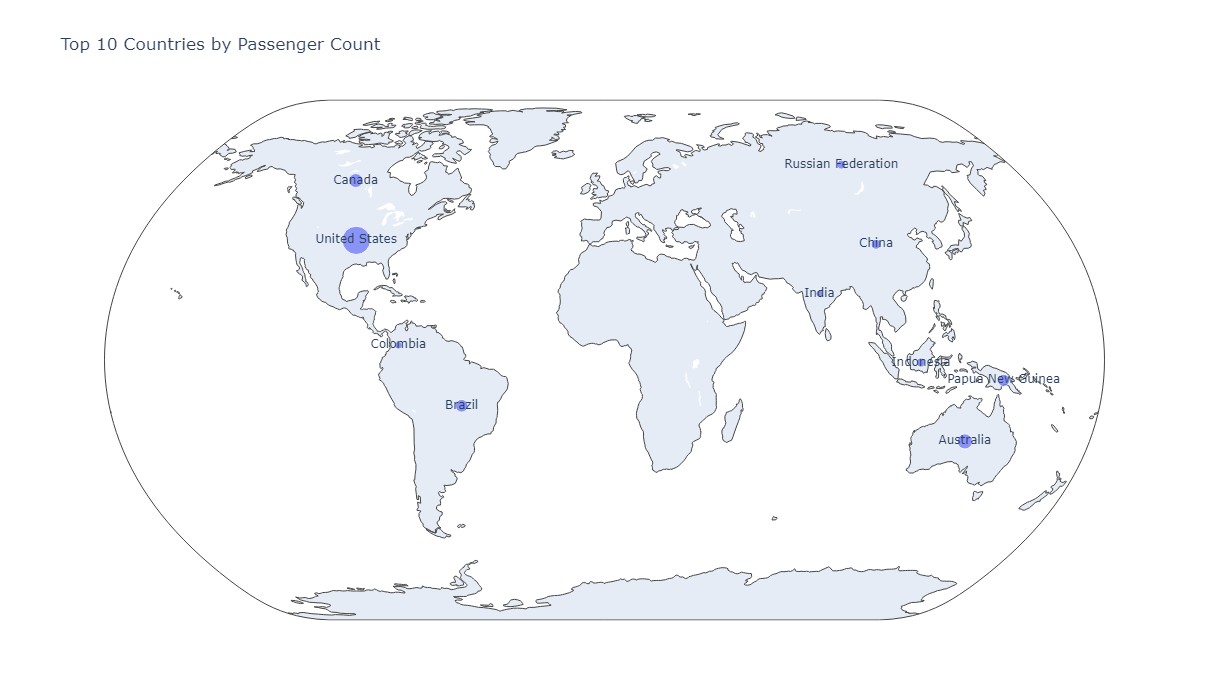

In [22]:



# Group by country and calculate passenger counts
top_countries_df = df_silver.groupBy("Country Name", "latitude", "longitude").count()

# Sort in descending order and take the top 10
top_countries_df = top_countries_df.orderBy(desc("count")).limit(10)

# Convert to pandas for Plotly visualization
top_countries_pd = top_countries_df.toPandas()


# Plot the map with top 10 countries
fig = px.scatter_geo(
    top_countries_pd,
    lat="latitude",
    lon="longitude",
    text="Country Name",
    size="count",
    title="Top 10 Countries by Passenger Count",
    projection="natural earth",
)

# Update layout to increase the figure size
fig.update_layout(
    width=1000,  # pixels
    height=700   
)

# Display the map
fig.show()

